In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import re
import os
import optuna

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, average_precision_score, confusion_matrix, 
    precision_score, recall_score, f1_score, log_loss, brier_score_loss, classification_report
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


# Settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("✅ Libraries Loaded.")

✅ Libraries Loaded.


In [144]:
df_model = pd.read_csv("../data/processed/Model_Training.csv")
print(f"Processed Features Shape: {df_model.shape}")

# We need these for the OOT split and the Profit Calculation.
raw_df = pd.read_csv("../data/raw/dataproject2025.csv")

# 1.3 Recover columns based on Index alignment
df_model['issue_d'] = raw_df['issue_d']
df_model.head()

Processed Features Shape: (1086236, 42)


,loan duration,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,fico_range_high,funded_amnt,inq_last_6mths,int_rate,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_bc_tl,num_il_tl,num_rev_accts,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,target,tax_liens,annual_inc_log,home_ownership_OWN,home_ownership_RENT,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,emp_length_num,issue_d
0,0,1379.0,21564.0,16.1,0.0,2.49,759.0,4800.0,2.0,10.99,220.0,25.0,25.0,0.0,25.0,2.0,4.0,1.0,7.0,3.0,0.0,0.0,4136.0,16.1,0,0.0,10.586610,False,False,False,False,True,False,False,False,False,False,False,False,False,False,2,2013
1,0,9570.0,16473.0,53.9,0.0,22.87,734.0,27050.0,0.0,10.99,326.0,16.0,6.0,4.0,16.0,2.0,8.0,8.0,15.0,14.0,0.0,0.0,36638.0,61.2,0,0.0,10.915107,True,False,False,True,False,False,False,False,False,False,False,False,False,False,10,2013
2,0,53306.0,13901.0,67.1,0.0,18.55,749.0,28000.0,1.0,7.62,229.0,5.0,2.0,5.0,5.0,4.0,8.0,11.0,15.0,15.0,0.0,0.0,29581.0,54.6,0,0.0,12.691584,False,False,False,True,False,False,False,False,False,False,False,False,False,False,5,2013
3,0,36362.0,3567.0,93.0,0.0,13.03,719.0,12000.0,1.0,11.99,193.0,4.0,4.0,3.0,85.0,3.0,4.0,8.0,8.0,9.0,0.0,0.0,10805.0,67.0,0,0.0,11.775297,False,False,False,True,False,False,False,False,False,False,False,False,False,False,10,2013
4,1,24161.0,4853.0,74.7,1.0,23.13,669.0,27600.0,1.0,19.97,294.0,4.0,4.0,4.0,4.0,5.0,11.0,4.0,16.0,10.0,0.0,0.0,27003.0,82.8,1,0.0,11.198228,False,False,False,True,False,False,False,False,False,False,False,False,False,False,6,2013


### 1. Data Splitting

In [145]:
os.makedirs('../data/processed', exist_ok=True)
OOT_TEST_YEAR = 2018 
target_col = 'target'
cols_to_exclude = ['target', 'issue_d']

print(f"✂️  Step 1: Time-based Split (OOT Year: {OOT_TEST_YEAR})...")

# 划分原始训练集和 OOT 测试集
train_df_raw = df_model[df_model['issue_d'] < OOT_TEST_YEAR].copy()
test_df = df_model[df_model['issue_d'] == OOT_TEST_YEAR].copy()

# --- 2. 提取特征与标签 (处理 Leakage) ---
def get_x_y(df):
    X = df.drop(columns=[c for c in cols_to_exclude if c in df.columns])
    y = df[target_col]
    return X, y

X_train_full, y_train_full = get_x_y(train_df_raw)
X_test, y_test = get_x_y(test_df)

# --- 3. 核心：二次划分“建模集”与“校准集” ---
# 注意：此步骤仅在进入 OOT 测试集之前的 train_full 上进行
print(f"🔧 Step 2: Sub-splitting Training set into Base and Calibration...")

X_train_base, X_val_cal, y_train_base, y_val_cal = train_test_split(
    X_train_full, 
    y_train_full, 
    test_size=0.20,      # 建议 20% 用于校准和超参数微调
    random_state=42, 
    stratify=y_train_full # 保持违约率比例一致
)

# --- 4. 提取财务信息 (用于业务价值分析) ---
financial_cols = ['funded_amnt', 'int_rate', 'target', 'issue_d']
test_financials = test_df[financial_cols].copy()

# --- 5. 最终检查与保存 ---
print("\n" + "="*30)
print(f"✅ Leakage Check: {'target' not in X_train_base.columns}")
print(f"📊 Final Data Shapes:")
print(f"   [Modeling]    X_train_base : {X_train_base.shape}")
print(f"   [Calibration] X_val_cal    : {X_val_cal.shape}")
print(f"   [OOT Test]    X_test       : {X_test.shape}")
print("="*30)

print("\n💾 Saving 7 files to '../data/processed/'...")

save_config = {
    "X_train_base": X_train_base, "y_train_base": y_train_base,
    "X_val_cal": X_val_cal, "y_val_cal": y_val_cal,
    "X_test": X_test, "y_test": y_test,
    "test_financials": test_financials
}

for name, data in save_config.items():
    data.to_csv(f'../data/processed/{name}.csv', index=False)

print("🚀 Success! All datasets prepared for training and calibration.")



✂️  Step 1: Time-based Split (OOT Year: 2018)...
🔧 Step 2: Sub-splitting Training set into Base and Calibration...

✅ Leakage Check: True
📊 Final Data Shapes:
   [Modeling]    X_train_base : (765716, 41)
   [Calibration] X_val_cal    : (191429, 41)
   [OOT Test]    X_test       : (94893, 41)

💾 Saving 7 files to '../data/processed/'...
🚀 Success! All datasets prepared for training and calibration.


In [146]:
# 1. Setup & OOT Split Configuration
os.makedirs('../data/processed', exist_ok=True)

OOT_TEST_YEAR = 2018 ##Due to Temporal Analysis

print(f"✂️  Splitting data based on Time (OOT Year: {OOT_TEST_YEAR})...")

train_df = df_model[df_model['issue_d'] < OOT_TEST_YEAR].copy()
test_df = df_model[df_model['issue_d'] == OOT_TEST_YEAR].copy()


# 2. Extract Financials (For Business Value Analysis)
print("Extracting financial info for Profit Analysis...")


financial_cols = ['funded_amnt', 'int_rate', 'target', 'issue_d']
test_financials = test_df[financial_cols].copy()

target_col = 'target'

# columns need to be deleted 
# - target: label
# - issue_d: prevent data leakage

cols_to_exclude = ['target', 'issue_d']


X_train = train_df.drop(columns=[c for c in cols_to_exclude if c in train_df.columns])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[c for c in cols_to_exclude if c in test_df.columns])
y_test = test_df[target_col]

# Leakage Check 
assert 'target' not in X_train.columns, "❌ Error: target still in X_train!"
print("✅ Leakage Check Passed.")

print(f"\n Final Shapes:")
print(f"   X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"   X_test : {X_test.shape}  | y_test : {y_test.shape}")
print(f"   Test Financials: {test_financials.shape}")

# 4. Save All Files to Disk

print("\ Saving all datasets to '../data/processed/'...")

X_train.to_csv('../data/processed/X_train.csv', index=False)
X_test.to_csv('../data/processed/X_test.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)
test_financials.to_csv('../data/processed/test_financials.csv', index=False)

print("✅ Success! 5 files saved (X_train, X_test, y_train, y_test, test_financials).")

✂️  Splitting data based on Time (OOT Year: 2018)...
Extracting financial info for Profit Analysis...
✅ Leakage Check Passed.

 Final Shapes:
   X_train: (957145, 41) | y_train: (957145,)
   X_test : (94893, 41)  | y_test : (94893,)
   Test Financials: (94893, 4)
\ Saving all datasets to '../data/processed/'...


<>:44: SyntaxWarning: invalid escape sequence '\ '
<>:44: SyntaxWarning: invalid escape sequence '\ '
/var/folders/5s/lfpnb79x1k35l8xqh6lj3t0r0000gn/T/ipykernel_31195/1715949794.py:44: SyntaxWarning: invalid escape sequence '\ '
  print("\ Saving all datasets to '../data/processed/'...")


✅ Success! 5 files saved (X_train, X_test, y_train, y_test, test_financials).


###  2. Baseline Model: Logistic Regression


In [147]:
print("\n🔄 Training Baseline (Logistic Regression)...")

# Pipeline: Scaling is mandatory for LR
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(class_weight='balanced', solver='liblinear', random_state=42))
])

lr_pipeline.fit(X_train_base, y_train_base)

# Predictions
y_prob_lr = lr_pipeline.predict_proba(X_test)[:, 1]
y_pred_lr = lr_pipeline.predict(X_test)

# 2. key metrics
lr_auc = roc_auc_score(y_test, y_prob_lr)
lr_pr = average_precision_score(y_test, y_prob_lr)
lr_gini = 2 * lr_auc - 1 # Gini Coefficient

# 3. based on threshold=0.5
lr_precision = precision_score(y_test, y_pred_lr, zero_division=0)
lr_recall = recall_score(y_test, y_pred_lr, zero_division=0)
lr_f1 = f1_score(y_test, y_pred_lr, zero_division=0)

cm = confusion_matrix(y_test, y_pred_lr)
cm_df = pd.DataFrame(cm, 
                     index=['Actual Non-Default (0)', 'Actual Default (1)'], 
                     columns=['Predicted Non-Default (0)', 'Predicted Default (1)'])

print("\n--- 🏁 Logistic Regression Performance Metrics (threshold=0.5)---")
print(f"| ROC AUC Score:     | {lr_auc:.4f} |")
print(f"| Gini Coefficient:  | {lr_gini:.4f} |")
print(f"| PR-AUC (Avg Prec): | {lr_pr:.4f} |")
print("-" * 37)
print(f"| Precision:         | {lr_precision:.4f} |")
print(f"| Recall:            | {lr_recall:.4f} |")
print(f"| F1-Score:          | {lr_f1:.4f} |")
print("-" * 37)
print("\n--- 🔢 Confusion Matrix ---")
print(cm_df.to_markdown())


🔄 Training Baseline (Logistic Regression)...

--- 🏁 Logistic Regression Performance Metrics (threshold=0.5)---
| ROC AUC Score:     | 0.6991 |
| Gini Coefficient:  | 0.3982 |
| PR-AUC (Avg Prec): | 0.4281 |
-------------------------------------
| Precision:         | 0.3945 |
| Recall:            | 0.6080 |
| F1-Score:          | 0.4785 |
-------------------------------------

--- 🔢 Confusion Matrix ---
|                        |   Predicted Non-Default (0) |   Predicted Default (1) |
|:-----------------------|----------------------------:|------------------------:|
| Actual Non-Default (0) |                       47873 |                   22699 |
| Actual Default (1)     |                        9535 |                   14786 |


### 3. Challenger Model: XGBoost Model

In [148]:
def clean_feature_names(df):
    clean_cols = []
    for col in df.columns:
        # Replace [, ], < with underscores or empty strings
        new_col = re.sub(r'[\[\]<]', '', col)
        clean_cols.append(new_col)
    df.columns = clean_cols
    return df

# Apply the fix
X_train_base = clean_feature_names(X_train_base)
X_test = clean_feature_names(X_test)

print("✅ Feature names sanitized (removed brackets and < symbols).")

# Update feature names list
feature_names = X_train_base.columns.tolist()


# Calculate Scale Pos Weight for Imbalance after EDA
ratio = (y_train_base == 0).sum() / (y_train_base == 1).sum()
print(f"Imbalance Ratio (scale_pos_weight): {ratio:.2f}")

xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,  # Critical for imbalance
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_clf.fit(X_train_base, y_train_base)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1] # Predictions

# Metrics
xgb_auc = roc_auc_score(y_test, y_prob_xgb)
xgb_pr = average_precision_score(y_test, y_prob_xgb)
print([xgb_auc, xgb_pr])


✅ Feature names sanitized (removed brackets and < symbols).
Imbalance Ratio (scale_pos_weight): 3.82
[0.713432966153217, 0.4510327946713218]


In [149]:
# Compute Metrics
roc_auc = roc_auc_score(y_test, y_prob_xgb)
gini_val = 2 * roc_auc - 1

metrics = {
    "ROC-AUC": roc_auc_score(y_test, y_prob_xgb),
    "PR-AUC": average_precision_score(y_test, y_prob_xgb),
    "Precision": precision_score(y_test, y_pred_xgb),
    "Recall": recall_score(y_test, y_pred_xgb),
    "F1-Score": f1_score(y_test, y_pred_xgb),
    "Gini Coefficient": gini_val,
    "Confusion Matrix": confusion_matrix(y_test, y_pred_xgb)
}

# Print all metrics
print("✅ XGBoost Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v}")

✅ XGBoost Metrics:
ROC-AUC: 0.713432966153217
PR-AUC: 0.4510327946713218
Precision: 0.3679836651352731
Recall: 0.7410057152255253
F1-Score: 0.4917594411700502
Gini Coefficient: 0.4268659323064341
Confusion Matrix: [[39619 30953]
 [ 6299 18022]]


### 4. Feature Importance Plot


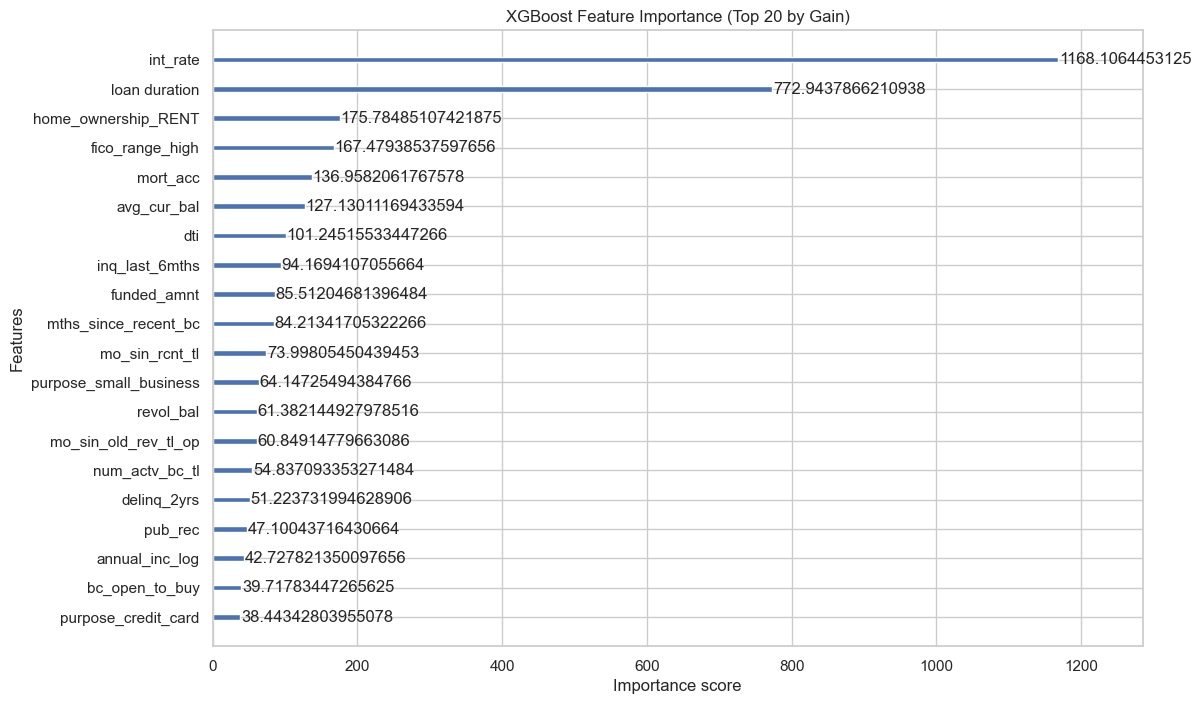


--- Top 10 Features by Gain ---
| Feature              |      Gain |
|:---------------------|----------:|
| int_rate             | 1168.11   |
| loan duration        |  772.944  |
| home_ownership_RENT  |  175.785  |
| fico_range_high      |  167.479  |
| mort_acc             |  136.958  |
| avg_cur_bal          |  127.13   |
| dti                  |  101.245  |
| inq_last_6mths       |   94.1694 |
| funded_amnt          |   85.512  |
| mths_since_recent_bc |   84.2134 |


In [150]:
# importance_type='gain' 
# Only plot max_num_features=20 
fig, ax = plt.subplots(figsize=(12, 8))

xgb.plot_importance(
    xgb_clf, 
    importance_type='gain', 
    max_num_features=20, 
    ax=ax,
    title="XGBoost Feature Importance (Top 20 by Gain)"
)
plt.show()

importance = xgb_clf.get_booster().get_score(importance_type='gain')
feature_importance_df = pd.DataFrame(
    list(importance.items()), 
    columns=['Feature', 'Gain']
).sort_values(by='Gain', ascending=False)

print("\n--- Top 10 Features by Gain ---")
print(feature_importance_df.head(10).to_markdown(index=False))

In [151]:
baseline_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print(f"--- baseline model performance ---")
print(f"features number: {X_train.shape[1]}")
print(f"Baeline AUC: {baseline_auc:.4f}\n")



def get_feature_contribution_df(model):
    importance = model.get_booster().get_score(importance_type='gain')

    df = pd.DataFrame(
        list(importance.items()), 
        columns=['Feature', 'Gain']
    )
    total_gain = df['Gain'].sum()
    df['Contribution_Pct'] = (df['Gain'] / total_gain) * 100
    return df.sort_values(by='Contribution_Pct', ascending=True)

bottom_features_pct_df = get_feature_contribution_df(xgb_clf)

print("--- bottom features contribution (ascending) ---")
print(bottom_features_pct_df.head(10).to_markdown(index=False, floatfmt=".4f"))



--- baseline model performance ---
features number: 41
Baeline AUC: 0.7134

--- bottom features contribution (ascending) ---
| Feature                    |    Gain |   Contribution_Pct |
|:---------------------------|--------:|-------------------:|
| purpose_renewable_energy   | 18.8891 |             0.4640 |
| revol_util                 | 25.2516 |             0.6203 |
| purpose_house              | 25.7073 |             0.6314 |
| purpose_other              | 26.0676 |             0.6403 |
| tax_liens                  | 26.1296 |             0.6418 |
| num_rev_accts              | 26.6003 |             0.6534 |
| purpose_debt_consolidation | 28.0631 |             0.6893 |
| num_il_tl                  | 28.7665 |             0.7066 |
| purpose_medical            | 29.0116 |             0.7126 |
| purpose_major_purchase     | 29.4791 |             0.7241 |


In [152]:
CANDIDATE_THRESHOLD_PCT = 1.0 

features_to_drop = bottom_features_pct_df[
    bottom_features_pct_df['Contribution_Pct'] < CANDIDATE_THRESHOLD_PCT
]['Feature'].tolist()

X_train_new = X_train.drop(columns=features_to_drop, errors='ignore')
X_test_new = X_test.drop(columns=features_to_drop, errors='ignore')

print(f"new features number: {X_train_new.shape[1]}")

print("\n🔄 Retraining the simplified model...")

xgb_clf_new = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=ratio,
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_clf_new.fit(X_train_new, y_train)

# 4: Performance Comparison

y_prob_xgb_new = xgb_clf_new.predict_proba(X_test_new)[:, 1]
new_auc = roc_auc_score(y_test, y_prob_xgb_new)
auc_change = new_auc - baseline_auc

print(f"\n--- Comparison after deletion features ---")
print(f"baseline AUC: {baseline_auc:.4f}")
print(f"new model AUC: {new_auc:.4f}")

if auc_change >= 0:
    print(f"conclusion: ✅ AUC increases/remains (+{auc_change:.4f})。succesfully deleted!！")
    print("next steps: use X_train_new and X_test_new for further optimization.")
else:
    print(f"conclusion: ❌ AUC decreases ({auc_change:.4f}). failed to delete")
    print("next steps: restore these features.try again with a stricter threshold or hyperparameter tuning.")

new features number: 18

🔄 Retraining the simplified model...

--- Comparison after deletion features ---
baseline AUC: 0.7134
new model AUC: 0.7108
conclusion: ❌ AUC decreases (-0.0026). failed to delete
next steps: restore these features.try again with a stricter threshold or hyperparameter tuning.


### 5. Finetuning Optuna

In [153]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 800),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'subsample': trial.suggest_float('subsample', 0.7, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9),
        'gamma': trial.suggest_float('gamma', 0, 0.2),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', ratio*0.9, ratio*1.1), # 在比例附近微调

        # fix other parameters
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_jobs': -1,
        'random_state': 42
    }

    # use stratified 3-fold CV to evaluate model potential 
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    auc_scores = []

    for train_idx, val_idx in cv.split(X_train_base, y_train_base):
        X_tr, X_val = X_train_base.iloc[train_idx], X_train_base.iloc[val_idx]
        y_tr, y_val = y_train_base.iloc[train_idx], y_train_base.iloc[val_idx]

        model = xgb.XGBClassifier(**params)
        model.fit(X_tr, y_tr)

        # calculate AUC
        y_prob = model.predict_proba(X_val)[:, 1]
        auc_scores.append(roc_auc_score(y_val, y_prob))

    # return average AUC
    return np.mean(auc_scores)

# 2. hyperparameter optimization 
print("🚀 Starting Hyperparameter Optimization for Ranking Ability...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, show_progress_bar=True)

print(f"✅ Optimization Complete. Best Gini Potential: {2 * study.best_value - 1:.4f}")

# 3. retrain final model  (Champion Model)
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'n_jobs': -1,
    'random_state': 42
})

champion_model = xgb.XGBClassifier(**best_params)
champion_model.fit(X_train_base, y_train_base)


[I 2025-12-19 00:32:35,879] A new study created in memory with name: no-name-5a521a2a-8e5c-4706-8181-2bb535d2821f


🚀 Starting Hyperparameter Optimization for Ranking Ability...


Best trial: 0. Best value: 0.712821:   7%|▋         | 1/15 [00:13<03:15, 13.99s/it]

[I 2025-12-19 00:32:49,873] Trial 0 finished with value: 0.7128212570500859 and parameters: {'n_estimators': 496, 'learning_rate': 0.05164375840370236, 'max_depth': 6, 'subsample': 0.8746667175592795, 'colsample_bytree': 0.8581941219128274, 'gamma': 0.035556235838082144, 'min_child_weight': 1, 'scale_pos_weight': 3.8350587304459407}. Best is trial 0 with value: 0.7128212570500859.


Best trial: 0. Best value: 0.712821:  13%|█▎        | 2/15 [00:19<02:00,  9.25s/it]

[I 2025-12-19 00:32:55,811] Trial 1 finished with value: 0.7105671267249191 and parameters: {'n_estimators': 244, 'learning_rate': 0.06933934458369519, 'max_depth': 4, 'subsample': 0.8491885899382877, 'colsample_bytree': 0.7649148534281665, 'gamma': 0.09077053859701407, 'min_child_weight': 6, 'scale_pos_weight': 4.109169567371773}. Best is trial 0 with value: 0.7128212570500859.


Best trial: 2. Best value: 0.713054:  20%|██        | 3/15 [00:31<02:03, 10.29s/it]

[I 2025-12-19 00:33:07,329] Trial 2 finished with value: 0.7130543119602833 and parameters: {'n_estimators': 425, 'learning_rate': 0.07053518478754213, 'max_depth': 5, 'subsample': 0.869893675940919, 'colsample_bytree': 0.7895589569294872, 'gamma': 0.016958322019934836, 'min_child_weight': 5, 'scale_pos_weight': 3.8959653213292786}. Best is trial 2 with value: 0.7130543119602833.


Best trial: 2. Best value: 0.713054:  27%|██▋       | 4/15 [00:40<01:46,  9.69s/it]

[I 2025-12-19 00:33:16,112] Trial 3 finished with value: 0.7055551320415688 and parameters: {'n_estimators': 398, 'learning_rate': 0.02047128372932083, 'max_depth': 3, 'subsample': 0.889357211586903, 'colsample_bytree': 0.7575008760994667, 'gamma': 0.19337598200396944, 'min_child_weight': 7, 'scale_pos_weight': 3.990582777940703}. Best is trial 2 with value: 0.7130543119602833.


Best trial: 2. Best value: 0.713054:  33%|███▎      | 5/15 [00:51<01:43, 10.35s/it]

[I 2025-12-19 00:33:27,620] Trial 4 finished with value: 0.7059108198961774 and parameters: {'n_estimators': 289, 'learning_rate': 0.010903143993511187, 'max_depth': 6, 'subsample': 0.8726836755886099, 'colsample_bytree': 0.7299398027609874, 'gamma': 0.13641764817761737, 'min_child_weight': 7, 'scale_pos_weight': 3.7149091725022294}. Best is trial 2 with value: 0.7130543119602833.


Best trial: 2. Best value: 0.713054:  40%|████      | 6/15 [01:12<02:05, 13.97s/it]

[I 2025-12-19 00:33:48,618] Trial 5 finished with value: 0.7104874110065659 and parameters: {'n_estimators': 553, 'learning_rate': 0.014902721201757441, 'max_depth': 6, 'subsample': 0.8550171791180434, 'colsample_bytree': 0.8469022593407457, 'gamma': 0.17132161551763622, 'min_child_weight': 7, 'scale_pos_weight': 3.6309757061873382}. Best is trial 2 with value: 0.7130543119602833.


Best trial: 2. Best value: 0.713054:  47%|████▋     | 7/15 [01:33<02:10, 16.30s/it]

[I 2025-12-19 00:34:09,729] Trial 6 finished with value: 0.7121726293368216 and parameters: {'n_estimators': 708, 'learning_rate': 0.023243508093681125, 'max_depth': 5, 'subsample': 0.7284835467930929, 'colsample_bytree': 0.8954827853534042, 'gamma': 0.1601899405071534, 'min_child_weight': 2, 'scale_pos_weight': 3.910680104365803}. Best is trial 2 with value: 0.7130543119602833.


Best trial: 2. Best value: 0.713054:  53%|█████▎    | 8/15 [01:49<01:53, 16.19s/it]

[I 2025-12-19 00:34:25,678] Trial 7 finished with value: 0.7078828449078581 and parameters: {'n_estimators': 624, 'learning_rate': 0.013173555671053197, 'max_depth': 4, 'subsample': 0.7469110968144741, 'colsample_bytree': 0.7648718253142732, 'gamma': 0.04117770727117154, 'min_child_weight': 5, 'scale_pos_weight': 3.7114228734033334}. Best is trial 2 with value: 0.7130543119602833.


Best trial: 2. Best value: 0.713054:  60%|██████    | 9/15 [02:01<01:29, 14.86s/it]

[I 2025-12-19 00:34:37,627] Trial 8 finished with value: 0.709974334869251 and parameters: {'n_estimators': 471, 'learning_rate': 0.027729824014140057, 'max_depth': 4, 'subsample': 0.7328329257415005, 'colsample_bytree': 0.8129326803531071, 'gamma': 0.1137798280519254, 'min_child_weight': 1, 'scale_pos_weight': 3.830375168034666}. Best is trial 2 with value: 0.7130543119602833.


Best trial: 2. Best value: 0.713054:  67%|██████▋   | 10/15 [02:19<01:18, 15.65s/it]

[I 2025-12-19 00:34:55,021] Trial 9 finished with value: 0.7119985057139945 and parameters: {'n_estimators': 502, 'learning_rate': 0.025649415823735016, 'max_depth': 6, 'subsample': 0.8564543924254012, 'colsample_bytree': 0.7359718034643796, 'gamma': 0.18971002020070726, 'min_child_weight': 1, 'scale_pos_weight': 4.180657859588796}. Best is trial 2 with value: 0.7130543119602833.


Best trial: 2. Best value: 0.713054:  73%|███████▎  | 11/15 [02:29<00:55, 13.88s/it]

[I 2025-12-19 00:35:04,899] Trial 10 finished with value: 0.7126118309344035 and parameters: {'n_estimators': 341, 'learning_rate': 0.0901067631344333, 'max_depth': 5, 'subsample': 0.804416940305823, 'colsample_bytree': 0.8051918631617732, 'gamma': 0.0015974896665590325, 'min_child_weight': 4, 'scale_pos_weight': 3.443523571969199}. Best is trial 2 with value: 0.7130543119602833.


Best trial: 2. Best value: 0.713054:  80%|████████  | 12/15 [02:41<00:40, 13.43s/it]

[I 2025-12-19 00:35:17,284] Trial 11 finished with value: 0.7124301220873784 and parameters: {'n_estimators': 408, 'learning_rate': 0.05124092623431433, 'max_depth': 5, 'subsample': 0.8115110097207858, 'colsample_bytree': 0.8593956883290134, 'gamma': 0.04700467513923355, 'min_child_weight': 3, 'scale_pos_weight': 3.9934282353532127}. Best is trial 2 with value: 0.7130543119602833.


Best trial: 12. Best value: 0.7132:  87%|████████▋ | 13/15 [03:01<00:30, 15.40s/it] 

[I 2025-12-19 00:35:37,222] Trial 12 finished with value: 0.7131996678928146 and parameters: {'n_estimators': 603, 'learning_rate': 0.04705720097725267, 'max_depth': 6, 'subsample': 0.8305183171732022, 'colsample_bytree': 0.8410288368465222, 'gamma': 0.0011653353160441943, 'min_child_weight': 4, 'scale_pos_weight': 3.8331373144439325}. Best is trial 12 with value: 0.7131996678928146.


Best trial: 13. Best value: 0.71346:  93%|█████████▎| 14/15 [03:23<00:17, 17.47s/it]

[I 2025-12-19 00:35:59,473] Trial 13 finished with value: 0.7134604732774883 and parameters: {'n_estimators': 784, 'learning_rate': 0.04076895827595735, 'max_depth': 5, 'subsample': 0.8220689929337766, 'colsample_bytree': 0.8303150208429906, 'gamma': 0.0009709088513998147, 'min_child_weight': 4, 'scale_pos_weight': 3.982078472051636}. Best is trial 13 with value: 0.7134604732774883.


Best trial: 13. Best value: 0.71346: 100%|██████████| 15/15 [03:47<00:00, 15.19s/it]


[I 2025-12-19 00:36:23,736] Trial 14 finished with value: 0.7131904814646223 and parameters: {'n_estimators': 770, 'learning_rate': 0.039884040770785105, 'max_depth': 6, 'subsample': 0.7751895306087454, 'colsample_bytree': 0.8354934660772905, 'gamma': 0.06830887647501795, 'min_child_weight': 4, 'scale_pos_weight': 4.050420594276057}. Best is trial 13 with value: 0.7134604732774883.
✅ Optimization Complete. Best Gini Potential: 0.4269


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8303150208429906
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [154]:
y_prob_raw = champion_model.predict_proba(X_test)[:, 1]

# key metrics
final_auc = roc_auc_score(y_test, y_prob_raw)
final_gini = 2 * final_auc - 1
avg_precision = average_precision_score(y_test, y_prob_raw) # PR-AUC
test_logloss = log_loss(y_test, y_prob_raw)
test_brier = brier_score_loss(y_test, y_prob_raw) 

print("\n" + "="*50)
print("🏁 CHAMPION MODEL COMPLETE ASSESSMENT (PRE-CALIBRATION)")
print("="*50)

print(f"\n[1. Ranking Ability (Core)]")
print(f"| ROC-AUC Score:      | {final_auc:.4f} |")
print(f"| Gini Coefficient:   | {final_gini:.4f} |")
print(f"| PR-AUC (Avg Prec):  | {avg_precision:.4f} | (More robust for imbalanced data)")

print(f"\n[2. Probabilistic Quality (Pre-calibration)]")
print(f"| Log Loss:           | {test_logloss:.4f} |")
print(f"| Brier Score:        | {test_brier:.4f} | (Closer to 0 indicates better probability accuracy)")

print("💡 Note: Precision/Recall values here are based on a 0.5 threshold for reference only.")
print("   These metrics will change significantly after finding the optimal threshold post-calibration.")


🏁 CHAMPION MODEL COMPLETE ASSESSMENT (PRE-CALIBRATION)

[1. Ranking Ability (Core)]
| ROC-AUC Score:      | 0.7158 |
| Gini Coefficient:   | 0.4317 |
| PR-AUC (Avg Prec):  | 0.4548 | (More robust for imbalanced data)

[2. Probabilistic Quality (Pre-calibration)]
| Log Loss:           | 0.6165 |
| Brier Score:        | 0.2152 | (Closer to 0 indicates better probability accuracy)
💡 Note: Precision/Recall values here are based on a 0.5 threshold for reference only.
   These metrics will change significantly after finding the optimal threshold post-calibration.


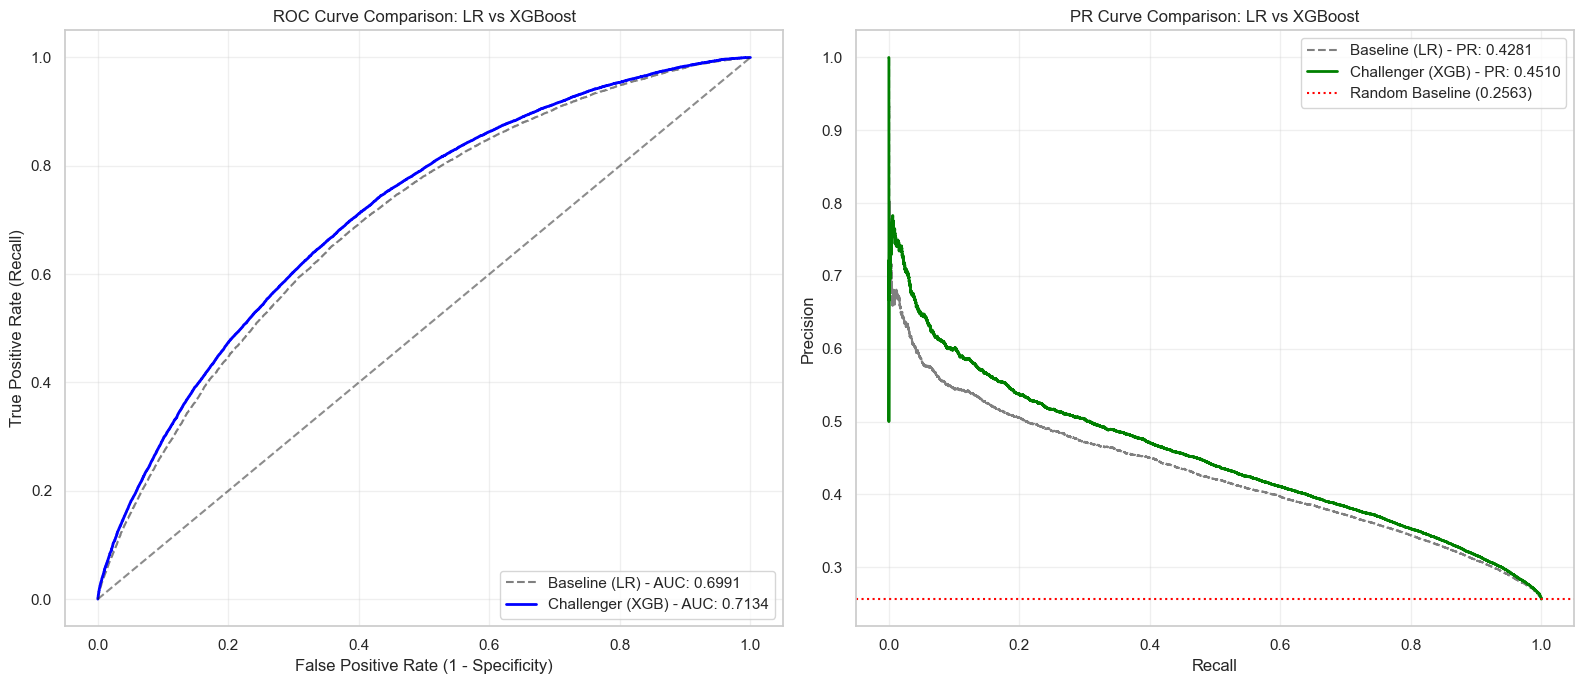

📈 Gini Improvement: 0.3982 -> 0.4269 (7.21% improvement)


In [155]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score

# --- A. ROC ---
# Baseline (Logistic Regression)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
auc_lr = roc_auc_score(y_test, y_prob_lr)

# Challenger model (XGBoost)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# --- B. PR ---
# Baseline (Logistic Regression)
prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_prob_lr)
pr_auc_lr = average_precision_score(y_test, y_prob_lr)

# Challenger model (XGBoost)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)
pr_auc_xgb = average_precision_score(y_test, y_prob_xgb)

plt.figure(figsize=(16, 7))

# 1. ROC comparison plot
plt.subplot(1, 2, 1)
plt.plot(fpr_lr, tpr_lr, label=f'Baseline (LR) - AUC: {auc_lr:.4f}', color='gray', linestyle='--')
plt.plot(fpr_xgb, tpr_xgb, label=f'Challenger (XGB) - AUC: {auc_xgb:.4f}', color='blue', lw=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5) # 随机猜测线
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve Comparison: LR vs XGBoost')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# 2. PR comparison plot 
plt.subplot(1, 2, 2)
plt.plot(rec_lr, prec_lr, label=f'Baseline (LR) - PR: {pr_auc_lr:.4f}', color='gray', linestyle='--')
plt.plot(rec_xgb, prec_xgb, label=f'Challenger (XGB) - PR: {pr_auc_xgb:.4f}', color='green', lw=2)
# compute random baseline
baseline = y_test.sum() / len(y_test)
plt.axhline(y=baseline, color='red', linestyle=':', label=f'Random Baseline ({baseline:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve Comparison: LR vs XGBoost')
plt.legend(loc='upper right')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Gini Improvement calculation 
gini_lr = 2 * auc_lr - 1
gini_xgb = 2 * auc_xgb - 1
improvement = (gini_xgb - gini_lr) / gini_lr * 100
print(f"📈 Gini Improvement: {gini_lr:.4f} -> {gini_xgb:.4f} ({improvement:.2f}% improvement)")

### 6. Calibration using Isotonic  Regression

/Users/kaixinxie/Credit_Risk_forCapgemini/.venv/lib/python3.12/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


🧪 Step 3: Evaluating on OOT Test set...


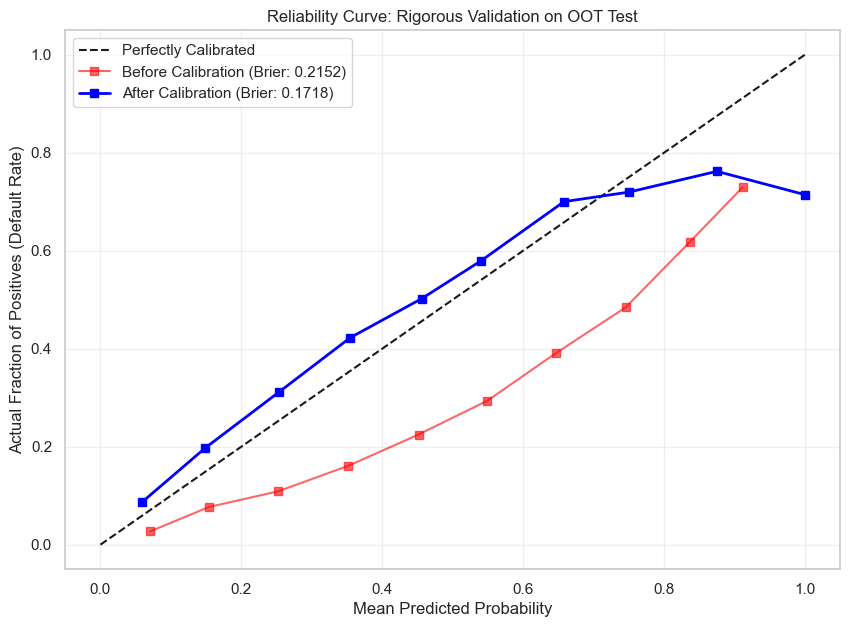

------------------------------
✅ Gini Check (Before): 0.4317
✅ Gini Check (After):  0.4315
✅ Brier Improvement:  0.2152 -> 0.1718
------------------------------


In [ ]:
calibrator = CalibratedClassifierCV(champion_model, cv='prefit', method='isotonic')
calibrator.fit(X_val_cal, y_val_cal)

# 3. on X_test / OOT
print("🧪 Step 3: Evaluating on OOT Test set...")
y_prob_raw = champion_model.predict_proba(X_test)[:, 1]
y_prob_calibrated = calibrator.predict_proba(X_test)[:, 1]

# 4. Brier Score (越小越好)
brier_before = brier_score_loss(y_test, y_prob_raw)
brier_after = brier_score_loss(y_test, y_prob_calibrated)

# 5. Reliability Curve
prob_true_raw, prob_pred_raw = calibration_curve(y_test, y_prob_raw, n_bins=10)
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_calibrated, n_bins=10)

plt.figure(figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
# Before
plt.plot(prob_pred_raw, prob_true_raw, 's-', color='red', alpha=0.6,
         label=f'Before Calibration (Brier: {brier_before:.4f})')
# After
plt.plot(prob_pred_cal, prob_true_cal, 's-', color='blue', lw=2,
         label=f'After Calibration (Brier: {brier_after:.4f})')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Actual Fraction of Positives (Default Rate)')
plt.title('Reliability Curve: Rigorous Validation on OOT Test')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

# 7. Final Check
print("-" * 30)
print(f"✅ Gini Check (Before): {2 * roc_auc_score(y_test, y_prob_raw) - 1:.4f}")
print(f"✅ Gini Check (After):  {2 * roc_auc_score(y_test, y_prob_calibrated) - 1:.4f}")
print(f"✅ Brier Improvement:  {brier_before:.4f} -> {brier_after:.4f}")
print("-" * 30)

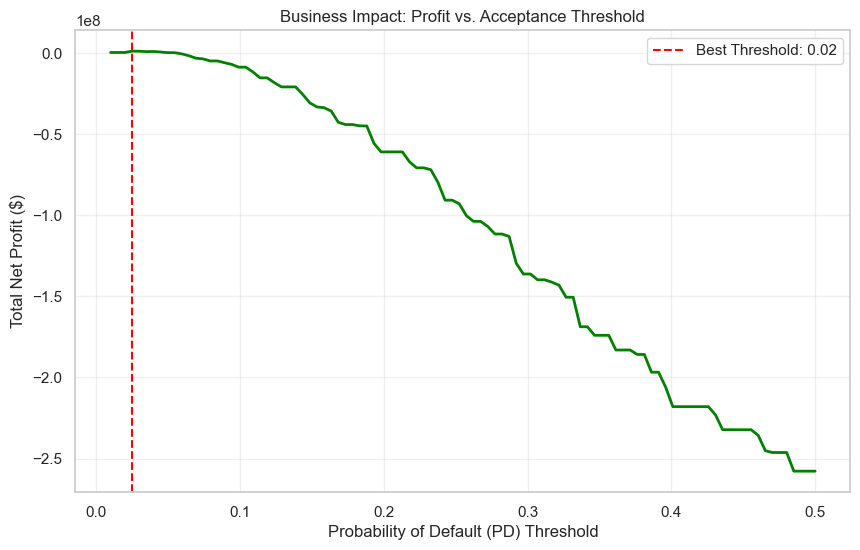

💰 Under the Calibrated Model:
✅ Optimal PD Threshold (Red Line): 0.02
✅ Expected Total Profit under this strategy: $1,381,058.71

📊 Comparison: If using 0.5 threshold blindly, profit is only: $-257,803,604.02
📈 Optimized threshold helped you earn an extra: $259,184,662.73


In [167]:
# 1. Prepare Financial Data (Assuming test_financials.csv is already loaded)
# Ensure the order of test_financials matches y_test
# financials = pd.read_csv('../data/processed/test_financials.csv')

# 2. Define Profit Calculation Function
def calculate_profit(y_true, y_prob, threshold, financials):
    # Determine whether to lend based on threshold (Predicting 0 means grant loan)
    will_lend = y_prob <= threshold
    
    # Profit Calculation Logic
    # TN: Loan granted and no default -> Earn Interest
    # FN: Loan granted and defaulted -> Lose Principal
    profit = np.where(
        (will_lend == True) & (y_true == 0), 
        financials['funded_amnt'] * (financials['int_rate'] / 100), # Interest Income
        np.where(
            (will_lend == True) & (y_true == 1),
            -financials['funded_amnt'], # Principal Loss
            0 # Loan rejected, profit is 0
        )
    )
    return np.sum(profit)

# 3. Iterate through thresholds to find the optimal solution
thresholds = np.linspace(0.01, 0.50, 100)
profits = [calculate_profit(y_test.values, y_prob_calibrated, t, test_financials) for t in thresholds]

best_idx = np.argmax(profits)
best_threshold = thresholds[best_idx]
max_profit = profits[best_idx]

# 4. Plotting: Profit vs. Threshold Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, profits, color='green', lw=2)
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title('Business Impact: Profit vs. Acceptance Threshold')
plt.xlabel('Probability of Default (PD) Threshold')
plt.ylabel('Total Net Profit ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"💰 Under the Calibrated Model:")
print(f"✅ Optimal PD Threshold (Red Line): {best_threshold:.2f}")
print(f"✅ Expected Total Profit under this strategy: ${max_profit:,.2f}")

# 5. Compare with 0.5 Threshold
profit_05 = calculate_profit(y_test.values, y_prob_calibrated, 0.5, test_financials)
print(f"\n📊 Comparison: If using 0.5 threshold blindly, profit is only: ${profit_05:,.2f}")
print(f"📈 Optimized threshold helped you earn an extra: ${max_profit - profit_05:,.2f}")

In [168]:
base_path = '/Users/kaixinxie/Credit_Risk_forCapgemini/models'
os.makedirs(base_path, exist_ok=True) # 如果文件夹不存在则创建

model_path = os.path.join(base_path, 'champion_model.joblib')
features_path = os.path.join(base_path, 'model_features.joblib')
calibrator_path = os.path.join(base_path, 'calibrator.joblib') # 建议也保存校准器

model_features = X_train_base.columns.tolist()


joblib.dump(champion_model, model_path)
print(f"\n✅ CHAMPION MODEL saved successfully to: {model_path}")
joblib.dump(model_features, features_path)
print(f"✅ FEATURE LIST saved successfully to: {features_path}")
joblib.dump(calibrator, calibrator_path)
print(f"✅ CALIBRATOR saved successfully to: {calibrator_path}")

print("\n🎉 All model components are secured and ready for deployment!")


✅ CHAMPION MODEL saved successfully to: /Users/kaixinxie/Credit_Risk_forCapgemini/models/champion_model.joblib
✅ FEATURE LIST saved successfully to: /Users/kaixinxie/Credit_Risk_forCapgemini/models/model_features.joblib
✅ CALIBRATOR saved successfully to: /Users/kaixinxie/Credit_Risk_forCapgemini/models/calibrator.joblib

🎉 All model components are secured and ready for deployment!


📊 Generating XGBoost Built-in Feature Importance (Gain)...


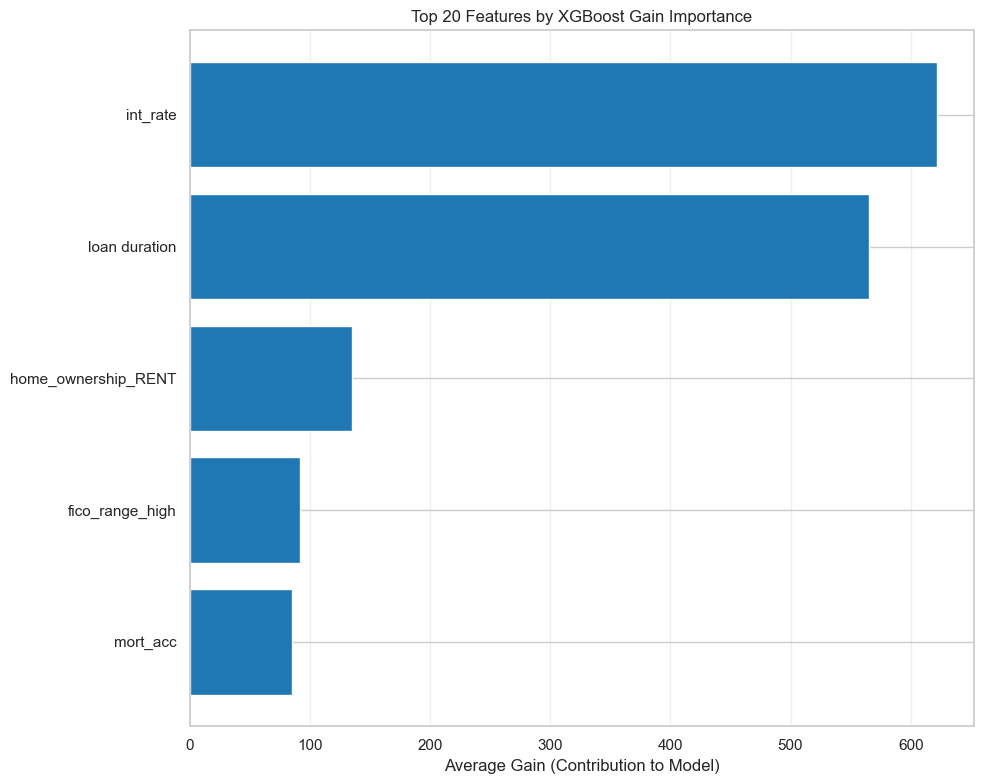


🧠 Generating SHAP Summary Plot (State-of-the-Art Interpretability)...
⏳ 计算 SHAP 值可能需要几分钟，请耐心等待...


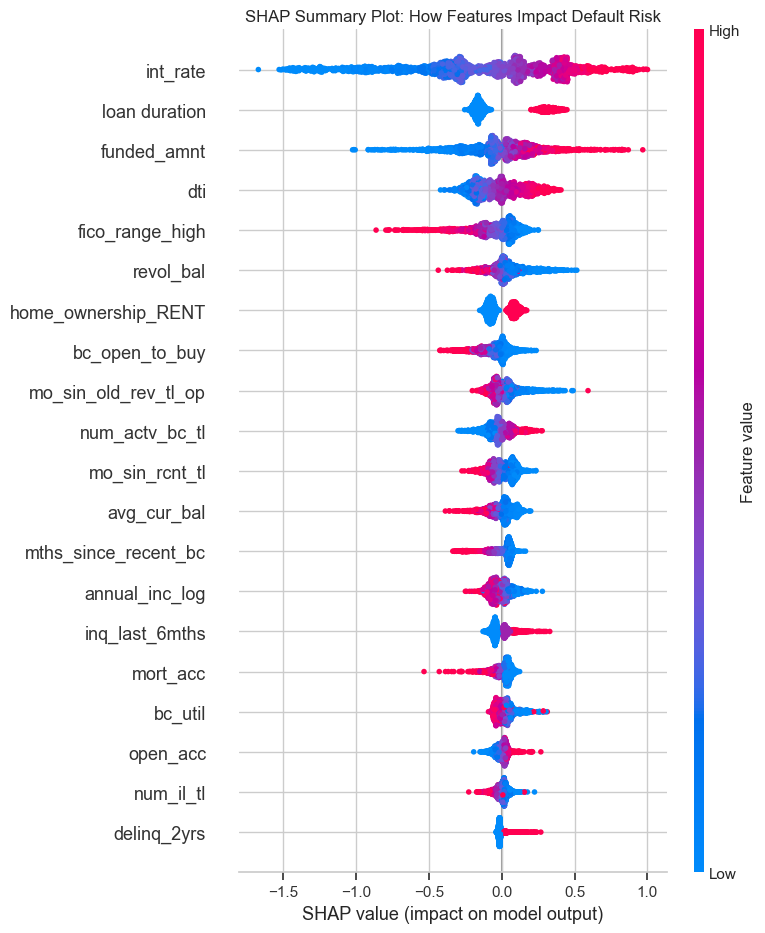

In [169]:
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import pandas as pd
import numpy as np

# =========================================
# 方法 A：XGBoost 内置特征重要性 (基于 Gain)
# =========================================
print("📊 Generating XGBoost Built-in Feature Importance (Gain)...")

# 获取特征重要性字典
importance_dict = champion_model.get_booster().get_score(importance_type='gain')

# 转换为 DataFrame 并排序
feat_imp = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Gain'])
feat_imp = feat_imp.sort_values(by='Gain', ascending=False).head(5) # 只看前5个

# 绘图
plt.figure(figsize=(10, 8))
plt.barh(feat_imp['Feature'][::-1], feat_imp['Gain'][::-1], color='#1f77b4')
plt.xlabel('Average Gain (Contribution to Model)')
plt.title('Top 20 Features by XGBoost Gain Importance')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# =========================================
# 方法 B：SHAP 值分析 (行业金标准 - 可解释性 AI)
# =========================================
print("\n🧠 Generating SHAP Summary Plot (State-of-the-Art Interpretability)...")
print("⏳ 计算 SHAP 值可能需要几分钟，请耐心等待...")

# 1. 创建解释器
# TreeExplainer 专用于树模型，速度快
explainer = shap.TreeExplainer(champion_model)

# 2. 计算 SHAP 值
# 为了速度，我们从测试集中随机抽取 2000 个样本进行分析（足够代表整体）
X_test_sample = X_test.sample(n=2000, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# 3. 绘制蜂群图 (Beeswarm Plot)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, plot_type="dot", show=False)
plt.title('SHAP Summary Plot: How Features Impact Default Risk')
plt.tight_layout()
plt.show()